<br><br><br><br><br>

# Coding fast and fast code

<br><br><br><br><br>

<center><img src="img/commute-by-plane.png" width="65%"></center>

_(Stolen from Jake Vanderplas.)_

<br><br><br><br><br>

**Extended analogy:** drive your car to the airport, then take an airplane.

<br><br><br><br><br>

<br><br>

#### Typical analysis workflow

   1. Start with small dataset; plot some things, compute some things, get a sense of the data.
   2. Collect one-liners, notebook cells, scripts into an executable.
   3. Run the executable on ever-larger datasets.
   4. Run it in different ways to quantify systematic errors.
   5. Realize that it wasn't written efficiently enough to finish analysis before deadline.
   6. Rewrite it in a faster language (e.g. Python → C++).
   7. Wonder why the new code doesn't reproduce the old results.

The problem is **step 6**: frameworks should allow you to improve (cleanliness, execution time) in _small steps,_ not _major rewrites._

<br><br>

In [2]:
# Example problem: computing a fractal (calendar/mousepad/T-shirt...).
import time, numpy

def run_python(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_python(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

5588.537206252416 ns per pixel


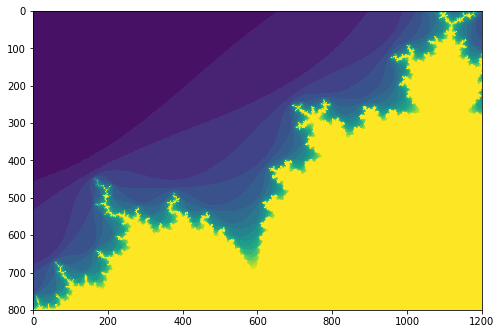

In [3]:
%matplotlib inline
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(figsize=(10, 5.5))
ax.imshow(fractal);

In [6]:
# Numpy operates array-at-a-time, you have to completely rethink the "iterate until converged" part.

def run_numpy(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_numpy(1600, 2400)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

359.64567214250565 ns per pixel


In [11]:
# But once it's in a Numpy-friendly form, it's ready for GPUs.
import cupy

def run_cupy(height, width, maxiterations=20):
    y, x = cupy.ogrid[-1:0:height*1j, -1.5:0:width*1j]               # <--- changed this line
    c = x + y*1j
    fractal = cupy.full(c.shape, maxiterations, dtype=numpy.int32)   # <--- changed this line
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_cupy(3200, 4800)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

72.87714009483655 ns per pixel


In [17]:
# Dask can keep all of your processors busy, but it might be making a more complex graph than you want.
import dask.array

def run_dask(height, width, maxiterations=20, hchunks=3, vchunks=4):
    chunked = lambda a: dask.array.from_array(a, chunks=(height // hchunks, width // vchunks))
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = chunked(x + y*1j)
    fractal = chunked(numpy.full(c.shape, maxiterations, dtype=numpy.int32))
    z = c
    for i in range(maxiterations):
        z = z**2 + c                                            # applying z → z² + c
        diverged = numpy.absolute(z) > 2                        # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == maxiterations)   # some are already done
        fractal[diverging_now] = i                              # just set the new ones
        z[diverged] = 2                                         # clamp diverged at 2
    return fractal

starttime = time.time()
fractal = run_dask(1600, 2400).compute()
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (1600 * 2400)))

214.84624594449997 ns per pixel


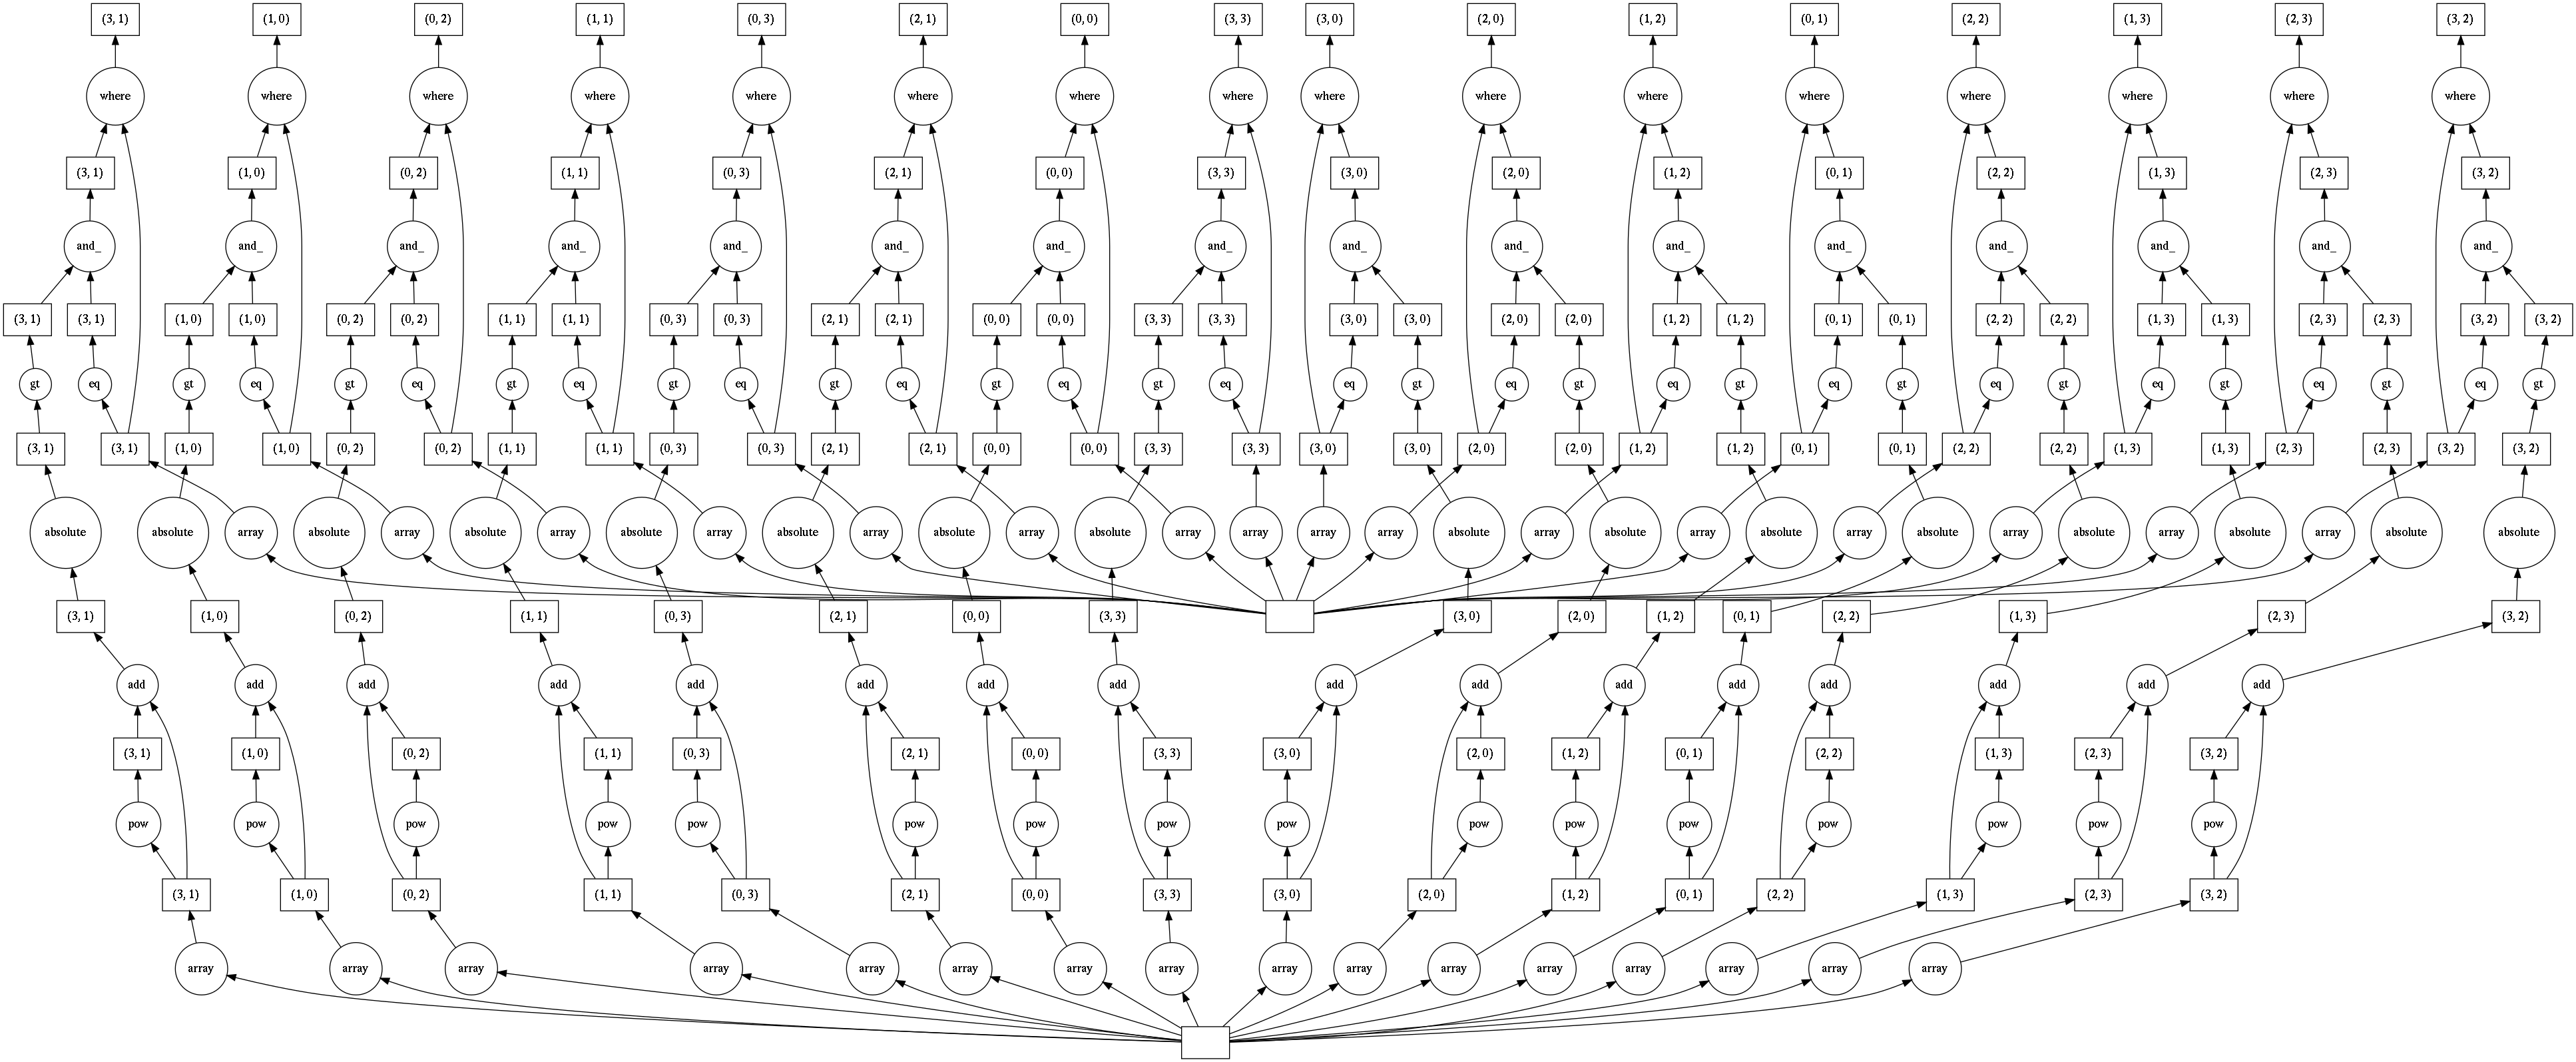

In [18]:
run_dask(1600, 2400, maxiterations=1, hchunks=3, vchunks=4).visualize()

In [21]:
# Numba, on the other hand, lets you run the original Python code, but faster.
import numba

@numba.jit
def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in range(height):
        for w in range(width):                  # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

111.45498525972168 ns per pixel


In [24]:
# Numba also has an OpenMP-like, "parallel for" (prange) to parallelize without complex dependencies.
import numba

@numba.jit(parallel=True)
def run_numba_parallel(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
    for h in numba.prange(height):
        for w in numba.prange(width):           # for each pixel (h, w)...
            z = c[h, w]
            for i in range(maxiterations):      # iterate at most 20 times
                z = z**2 + c[h, w]              # applying z → z² + c
                if abs(z) > 2:                  # if it diverges (|z| > 2)
                    fractal[h, w] = i           # color the plane with the iteration number
                    break                       # we're done, no need to keep iterating
    return fractal

starttime = time.time()
fractal = run_numba_parallel(6400, 9600)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (6400 * 9600)))

33.89562092100581 ns per pixel


In [27]:
# Numba can compile to GPUs, too, but you have to identify the kernel and set block sizes.
import numba.cuda, math
def run_numba_cuda(height, width, maxiterations=20):
    fractal = numpy.empty((height, width), dtype=numpy.int32)
    griddim = (math.ceil(height / 32), math.ceil(width / 32))
    blockdim = (32, 32)
    inner_loop_cuda[griddim, blockdim](height, width, maxiterations, fractal)
    return fractal
@numba.cuda.jit
def inner_loop_cuda(height, width, maxiterations, fractal):
    x, y = numba.cuda.grid(2)                   # 2-dimensional CUDA grid
    z = c = -1.5 + y*1.0/(height + 1) + -1j + x*1j*1.5/(width + 1)
    fractal[x, y] = maxiterations
    for i in range(maxiterations):      # iterate at most 20 times
        z = z**2 + c                    # applying z → z² + c
        if abs(z) > 2:                  # if it diverges (|z| > 2)
            fractal[x, y] = i           # color the plane with the iteration number
            break                       # we're done, no need to keep iterating
starttime = time.time()
fractal = run_numba_cuda(12800, 19200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (12800 * 19200)))

6.954927812330425 ns per pixel


In [28]:
%load_ext Cython

# Cython is a language that mixes C++ and Python. Can it help?

In [36]:
%%cython --cplus -c-O3
import cython, numpy       # load Python interface to Numpy
cimport numpy              # load C++ interface to Numpy (types end in _t)

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping (e.g. -1 for last element)
def run_cython(int height, int width, int maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32) + maxiterations
    cdef numpy.ndarray[numpy.complex128_t, ndim=2, mode="c"] c_array = c
    cdef numpy.ndarray[numpy.int32_t,      ndim=2, mode="c"] fractal_array = fractal
    cdef numpy.complex128_t z
    for h in range(height):
        for w in range(width):
            z = c_array[h, w]
            for i in range(maxiterations):
                z = z**2 + c_array[h, w]
                if abs(z) > 2:
                    fractal_array[h, w] = i
                    break
    return fractal

In [38]:
# Even with all the work we had to do, Cython's performance is underwhelming.

starttime = time.time()
fractal = run_cython(800, 1200)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (800 * 1200)))

1501.8736322720845 ns per pixel


In [39]:
%%writefile run_pybind11.cpp
#include <complex>
#include <pybind11/pybind11.h>    // pybind11: another (better) way to compile C++ for Python.
#include <pybind11/numpy.h>
namespace py = pybind11;
void run(int height, int width, int maxiterations,
         py::array_t<std::complex<double>> np_c, py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (std::abs(z) > 2) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
PYBIND11_MODULE(run_pybind11, m) {
    m.def("run", &run, "the inner loop");
}

Overwriting run_pybind11.cpp


In [40]:
%%bash

# Compile it as a Python extension module.

c++ -Wall -shared -std=c++11 -fPIC -O3                 \
    `python -m pybind11 --includes` run_pybind11.cpp   \
    -o run_pybind11`python3-config --extension-suffix`

In [43]:
import run_pybind11

starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
run_pybind11.run(height, width, maxiterations, c, fractal)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

165.4579769819975 ns per pixel


In [44]:
%%writefile run_pybind11_fastmath.cpp
#include <complex>
#include <pybind11/pybind11.h>    // We'll be compiling with -ffast-math (so we need a new name)!
#include <pybind11/numpy.h>
namespace py = pybind11;
void run(int height, int width, int maxiterations,
         py::array_t<std::complex<double>> np_c, py::array_t<int> np_fractal) {
    std::complex<double>* c = static_cast<std::complex<double>*>(np_c.request().ptr);
    int* fractal = static_cast<int*>(np_fractal.request().ptr);
    for (int h = 0;  h < height;  h++) {
        for (int w = 0;  w < width;  w++) {
            std::complex<double> ci = c[h + height*w];
            std::complex<double> z = ci;
            for (int i = 0;  i < maxiterations;  i++) {
                z = z*z + ci;
                if (std::abs(z) > 2) {
                    fractal[h + height*w] = i;
                    break;
}}}}}
PYBIND11_MODULE(run_pybind11_fastmath, m) {
    m.def("run", &run, "the inner loop");
}

Overwriting run_pybind11_fastmath.cpp


In [45]:
%%bash

# This time, compile with -ffast-math: trades floating point accuracy for speed.

c++ -Wall -shared -std=c++11 -fPIC -O3 -ffast-math              \
    `python -m pybind11 --includes` run_pybind11_fastmath.cpp   \
    -o run_pybind11_fastmath`python3-config --extension-suffix`

In [48]:
import run_pybind11_fastmath

starttime = time.time()
height, width, maxiterations = 3200, 4800, 20
y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
c = x + y*1j
fractal = numpy.full(c.shape, maxiterations, dtype=numpy.int32)
run_pybind11_fastmath.run(height, width, maxiterations, c, fractal)
print("{0} ns per pixel".format(1e9 * (time.time() - starttime) / (3200 * 4800)))

63.10312698284785 ns per pixel


### Summary

The times measured above are collected here, in order of my subjective estimate of setup difficulty.

| Method            | Setup       | time (ns/px) | speedup | Cores    |
|:------------------|:-----------:|-------------:|--------:|:--------:|
| Python            | automatic   | 5588.5       | 1×      | 1        |
| Numba             | automatic   | 111.4        | 50×     | 1        |
| Numba-parallel    | easy        | 33.89        | 165×    | all (12) |
| Numpy             | medium      | 359.6        | 15×     | 1        |
| CuPy              | medium      | 72.8         | 77×     | GPU      |
| Dask              | medium      | 214.8        | 26×     | all (12) |
| Numba-CUDA        | difficult   | 6.95         | 800×    | GPU      |
| pybind11          | challenging | 165.4        | 34×     | 1        |
| pybind11-fastmath | challenging | 63.1         | 90×     | 1        |
| Cython            | maddening   | 1501.8       | 3.7×    | 1        |

Pure Python is "automatic" because it's what you start with, and the Numpy-based methods are "medium" because you have to rethink your problem. CUDA kernel management is another layer of difficulty, and translating into another language (C++ or Cython) is the biggest hurdle.

The number of cores qualifies the speedup, and GPU methods rely on special hardware. Perfect scaling was never observed; independent, pinned, single-core processes could possibly do better.